## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось


## Важно 2 (0 - 0.15 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы.



## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. 
В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например дополнительные лоссы для стабилизации, WGAN-GP, а не GAN/WGAN+clip)


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader


import torchvision
from torchvision import transforms

from tqdm.notebook import tqdm
from IPython.display import clear_output

import numpy as np
import pandas as pd
import random
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

В этом домашнем задании мы будем работать с Celeba. Celeba - это уже известный вам датасет состоящий из фотографий селеб в их привычной местности:

In [2]:
#!pip install gdown

In [3]:
import gdown

url = 'https://drive.google.com/u/0/uc?id=16gqSgqCiIQAFlZNFV_tdGQK5Q1mijc7u'
output = 'celeba.zip'
#gdown.download(url, output, quiet=False)

In [4]:
# unzips

In [5]:
#! pip install unzip-aes

In [6]:
#!unzip-aes -p Password celeba.zip

In [7]:
#ls

In [8]:
#ls

In [9]:
#cd celeba/

In [10]:
#cd celeba/

In [11]:
#rm -R img_align_celeba/

In [12]:
#!unzip-aes -p Password img_align_celeba.zip

In [13]:
#cd ..

In [14]:
#cd ..

В этой домашней работе вам предлагается повторить результаты статьи StarGAN (https://arxiv.org/abs/1711.09020). 

Основная часть домашнего задания - чтение статьи и улучшение результатов, поэтому обязательно прочитайте не только StarGAN, но и другие Image-to-Image GAN подходы того времени (17-18 год) 


## Задача 1 (0.4 балла):

Повторить результаты StarGAN используя только CelebA

что это значит: в статье предлагается способ использовать несколько датасетов и выучивание аттрибутов уникальных для какого-то одного датасета. Мы не просим вас это делать, вам достаточно просто обучить StarGAN на CelebA

### Config

In [15]:
from my_utils import set_seed, count_parameters

set_seed(21)

In [16]:
class DotDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [17]:
config = {
    'image_size': 128,
    'batch_size': 64,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'num_epochs': 20,
    'grad_clip_value': 5
}
config = DotDict(config)

### Generator/Critic config
config['n_domains'] = 5       # len(true_domains)
config['n_c'] = config.n_domains + 2
config['n_channels'] = 64


### Training and Optimization config
config['lambda_gp']  = 10
config['lambda_cls'] = 1 * 3
config['lambda_rec'] = 10
config['n_critic']   = 5     # "We perform one generator update after five discriminator updates"
config['betas'] = (0.6, 0.999)   # 0.9 0.999
config['lr_start'] = 0.0002      # 0.001

### WandB

In [27]:
import wandb
wandb.login(key='your api')

def wandb_start(config, run_name):
    wandb.init(project="dgm-ht2", config=config)
    wandb.run.name = run_name
    
    return True

wandb: Currently logged in as: kirili4ik (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
wandb_start(config, 'bs64+cls*3+дооб')

True

### Data

Аугментации:

Авторы пишут: 
We crop the initial 178×218 size
images to 178×178, then resize them as 128×128. We randomly select 2,000 images as test set and use all remaining
images for training data

In [18]:
my_transforms = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [19]:
my_dataset = torchvision.datasets.CelebA('celeba', split='all', target_type='attr', transform=my_transforms, 
                                         download=False)

all_size = len(my_dataset)
print('all train+val samples:', all_size)

all train+val samples: 202599


In [20]:
val_size = 2000
train_size = all_size - val_size

In [21]:
train_set, val_set = torch.utils.data.random_split(my_dataset, [train_size, val_size])

In [22]:
train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
fid_loader = DataLoader(val_set, batch_size=config.batch_size, shuffle=False, drop_last=True)

Также авторы пишут, что используют только 7 domains:

"We construct seven domains using
the following attributes: hair color (black, blond, brown),
gender (male/female), and age (young/old)."

Так и сделаем:

In [23]:
domains = {'Black_Hair', 'Blond_Hair', 'Brown_Hair', 
           'Male', 'Young'}   # 0/1 = male/female, 0/1 = young/old

In [24]:
index2attr = {i:j for i, j in enumerate(my_dataset.attr_names)}
true_index2attr = {}

for index in range(len(index2attr)):
    domain = index2attr[index]
    if domain in domains:
        true_index2attr[index] = domain
print(true_index2attr)

{8: 'Black_Hair', 9: 'Blond_Hair', 11: 'Brown_Hair', 20: 'Male', 39: 'Young'}


In [25]:
true_domains      = np.array(list(true_index2attr.values()))
print(true_domains)
true_domains_nums = np.array(list(true_index2attr.keys()))
print(true_domains_nums)

['Black_Hair' 'Blond_Hair' 'Brown_Hair' 'Male' 'Young']
[ 8  9 11 20 39]


### Testing:

0 0 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])
-1 1 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])
0 0 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])
-1 1 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])
-1 1 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])
0 1 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])
-1 1 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])
-1 0 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])
-1 1 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])
-1 0 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])
-1 1 torch.Size([1, 3, 128, 128]) torch.Size([1, 5])


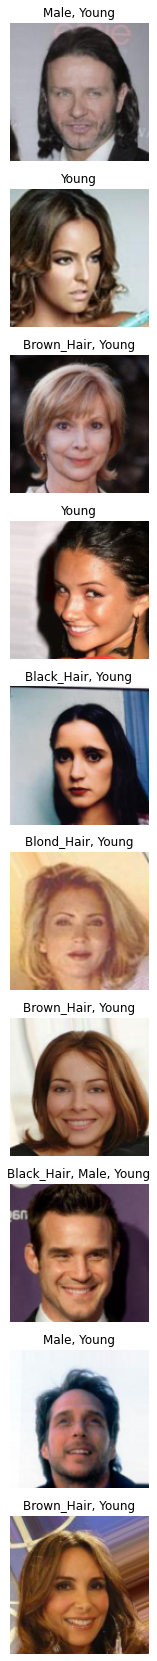

In [26]:
plt.figure(figsize=(30, 30))

# Проверим на val_loader - для консистентности и проверки поворотов
for index, (image, attr) in enumerate(val_loader):
    
    attr = attr[:, true_domains_nums]
    
    print(int(image.min()), int(image.max()), image.size(), attr.size())
    image = image[0]
    attr = attr[0]
    if index >= 10: break
    plt.subplot(10, 1, index+1)
    plt.imshow((image.squeeze().permute(1, 2, 0) + 1) / 2)
    plt.title(', '.join([true_domains[att_i] for att_i, att_val in enumerate(attr.view(-1)) 
                         if att_val == 1]))
    plt.axis('off')

plt.show()

Вот они! Наши герои! Те лица, на которые я смотрел 50+ последних часов!!!!

Картинки от -1 до 1, а рисуем от 0 до 1.

## Задача 2 (0.2 балла): 

Мерить качество на глаз - плохая идея. Подключите подсчет FID для каждой N эпохи, чтобы вы могли следить за прогрессом модели.

Сранение моделей между собой тоже возможно только по FID, поэтому трекайте его когда будете делать другие эксперименты

### FID

In [27]:
from inception import InceptionV3

classifier = InceptionV3()
classifier.to(config.device)
print()

In [28]:
from my_calculate_fid import calculate_fid

#%timeit calculate_fid(config, fid_loader, model, classifier)

17.1 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Не очень долго. Можно делать периодически

### Model

In [29]:
from model import StarGAN
model = StarGAN(config)
print(count_parameters(model.G) + count_parameters(model.D), config.device)
model.to(config.device)

52616070 cuda


In [30]:
wandb.watch(model.G)

NameError: name 'wandb' is not defined

In [31]:
wandb.watch(model.D)

NameError: name 'wandb' is not defined

In [42]:
from torch.optim.lr_scheduler import StepLR

G_scheduler = StepLR(model.G_optimizer, step_size=1, gamma=0.8)
D_scheduler = StepLR(model.D_optimizer, step_size=1, gamma=0.8)

In [46]:
for ep_num in range(config.num_epochs): 
    model.train()
    for index, (image, label) in enumerate(tqdm(train_loader, leave=False, desc=f"trainloop: {ep_num}")):
        label = label[:, true_domains_nums].type(torch.float)
        image = image.to(config.device)
        label = label.to(config.device)
        target_label = generate_target_label(config.batch_size, config.n_domains, config.device)

        ### Train Critic
        D_src_loss, L_real_cls, gp, D_loss = model.trainD(image, label, target_label)

        ### Train Generator
        if (index + 1) % config.n_critic == 0:
            G_src_loss, L_fake_cls, L_rec, G_loss = model.trainG(image, label, target_label)
            wandb.log({'D_real/fake':D_src_loss,   # D-0/1 from real
                       '(D)Real_class':L_real_cls,
                       '(D)Grad_pen':gp,
                       'D_loss':D_loss,
                       'G_real/fake':G_src_loss,   # D-0/1 from fake
                       '(G)Fake_class':L_fake_cls,
                       '(G)Reconstruction_loss':L_rec,
                       'G_loss':G_loss})   

        torch.nn.utils.clip_grad_norm_(model.G.parameters(), config.grad_clip_value)
        torch.nn.utils.clip_grad_norm_(model.D.parameters(), config.grad_clip_value)
        
        # After 10 epochs scheduler
        if ep_num > 10 and index == 0:
            G_scheduler.step()
            D_scheduler.step()
        
        # wandb logging
        if (ep_num < 2 and (index + 1) % 300 == 0) or (index+1) % 1500 == 0:
            model.eval()
            
            if (index + 1) % 600 == 0:
                fid = calculate_fid(config, fid_loader, model, classifier)
                wandb.log({'FID':fid})
                
            for ind, (image, label) in enumerate(val_loader): # batch = 1
                if ind >= 10: break

                # пример сравнения качества на глаз:
                target_label = generate_target_label(1, config.n_domains, config.device)
                #target_label = torch.randint(high=2, size=(1, config.n_domains), device=config.device).type(torch.float)

                fake_image = model.generate(image.to(config.device), target_label).detach().cpu()[0]
                image = image.detach().cpu()[0]
                target_label = target_label.squeeze().type(torch.long).detach().cpu().numpy()
                
                wandb.log({"samples": [wandb.Image((image.permute(1, 2, 0).numpy() + 1) / 2, caption='real'),
                                       wandb.Image((fake_image.permute(1, 2, 0).numpy() + 1) / 2, 
                                                   caption=str(true_domains[target_label == 1]))]
                          })
            model.train()
    
    torch.save({
        'G_st_dict': model.G.state_dict(),
        'D_st_dict': model.D.state_dict(),
        'G_optim':   model.G_optimizer.state_dict(),
        'D_optim':   model.D_optimizer.state_dict(),
    }, 'checkpoint_' + str(ep_num + 1))

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


KeyboardInterrupt: 

In [49]:
true_domains

array(['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'],
      dtype='<U10')

In [ ]:
 
axs[0, 0].plot(x, y)
axs[0, 0]

IndexError: index 8 is out of bounds for dimension 0 with size 1

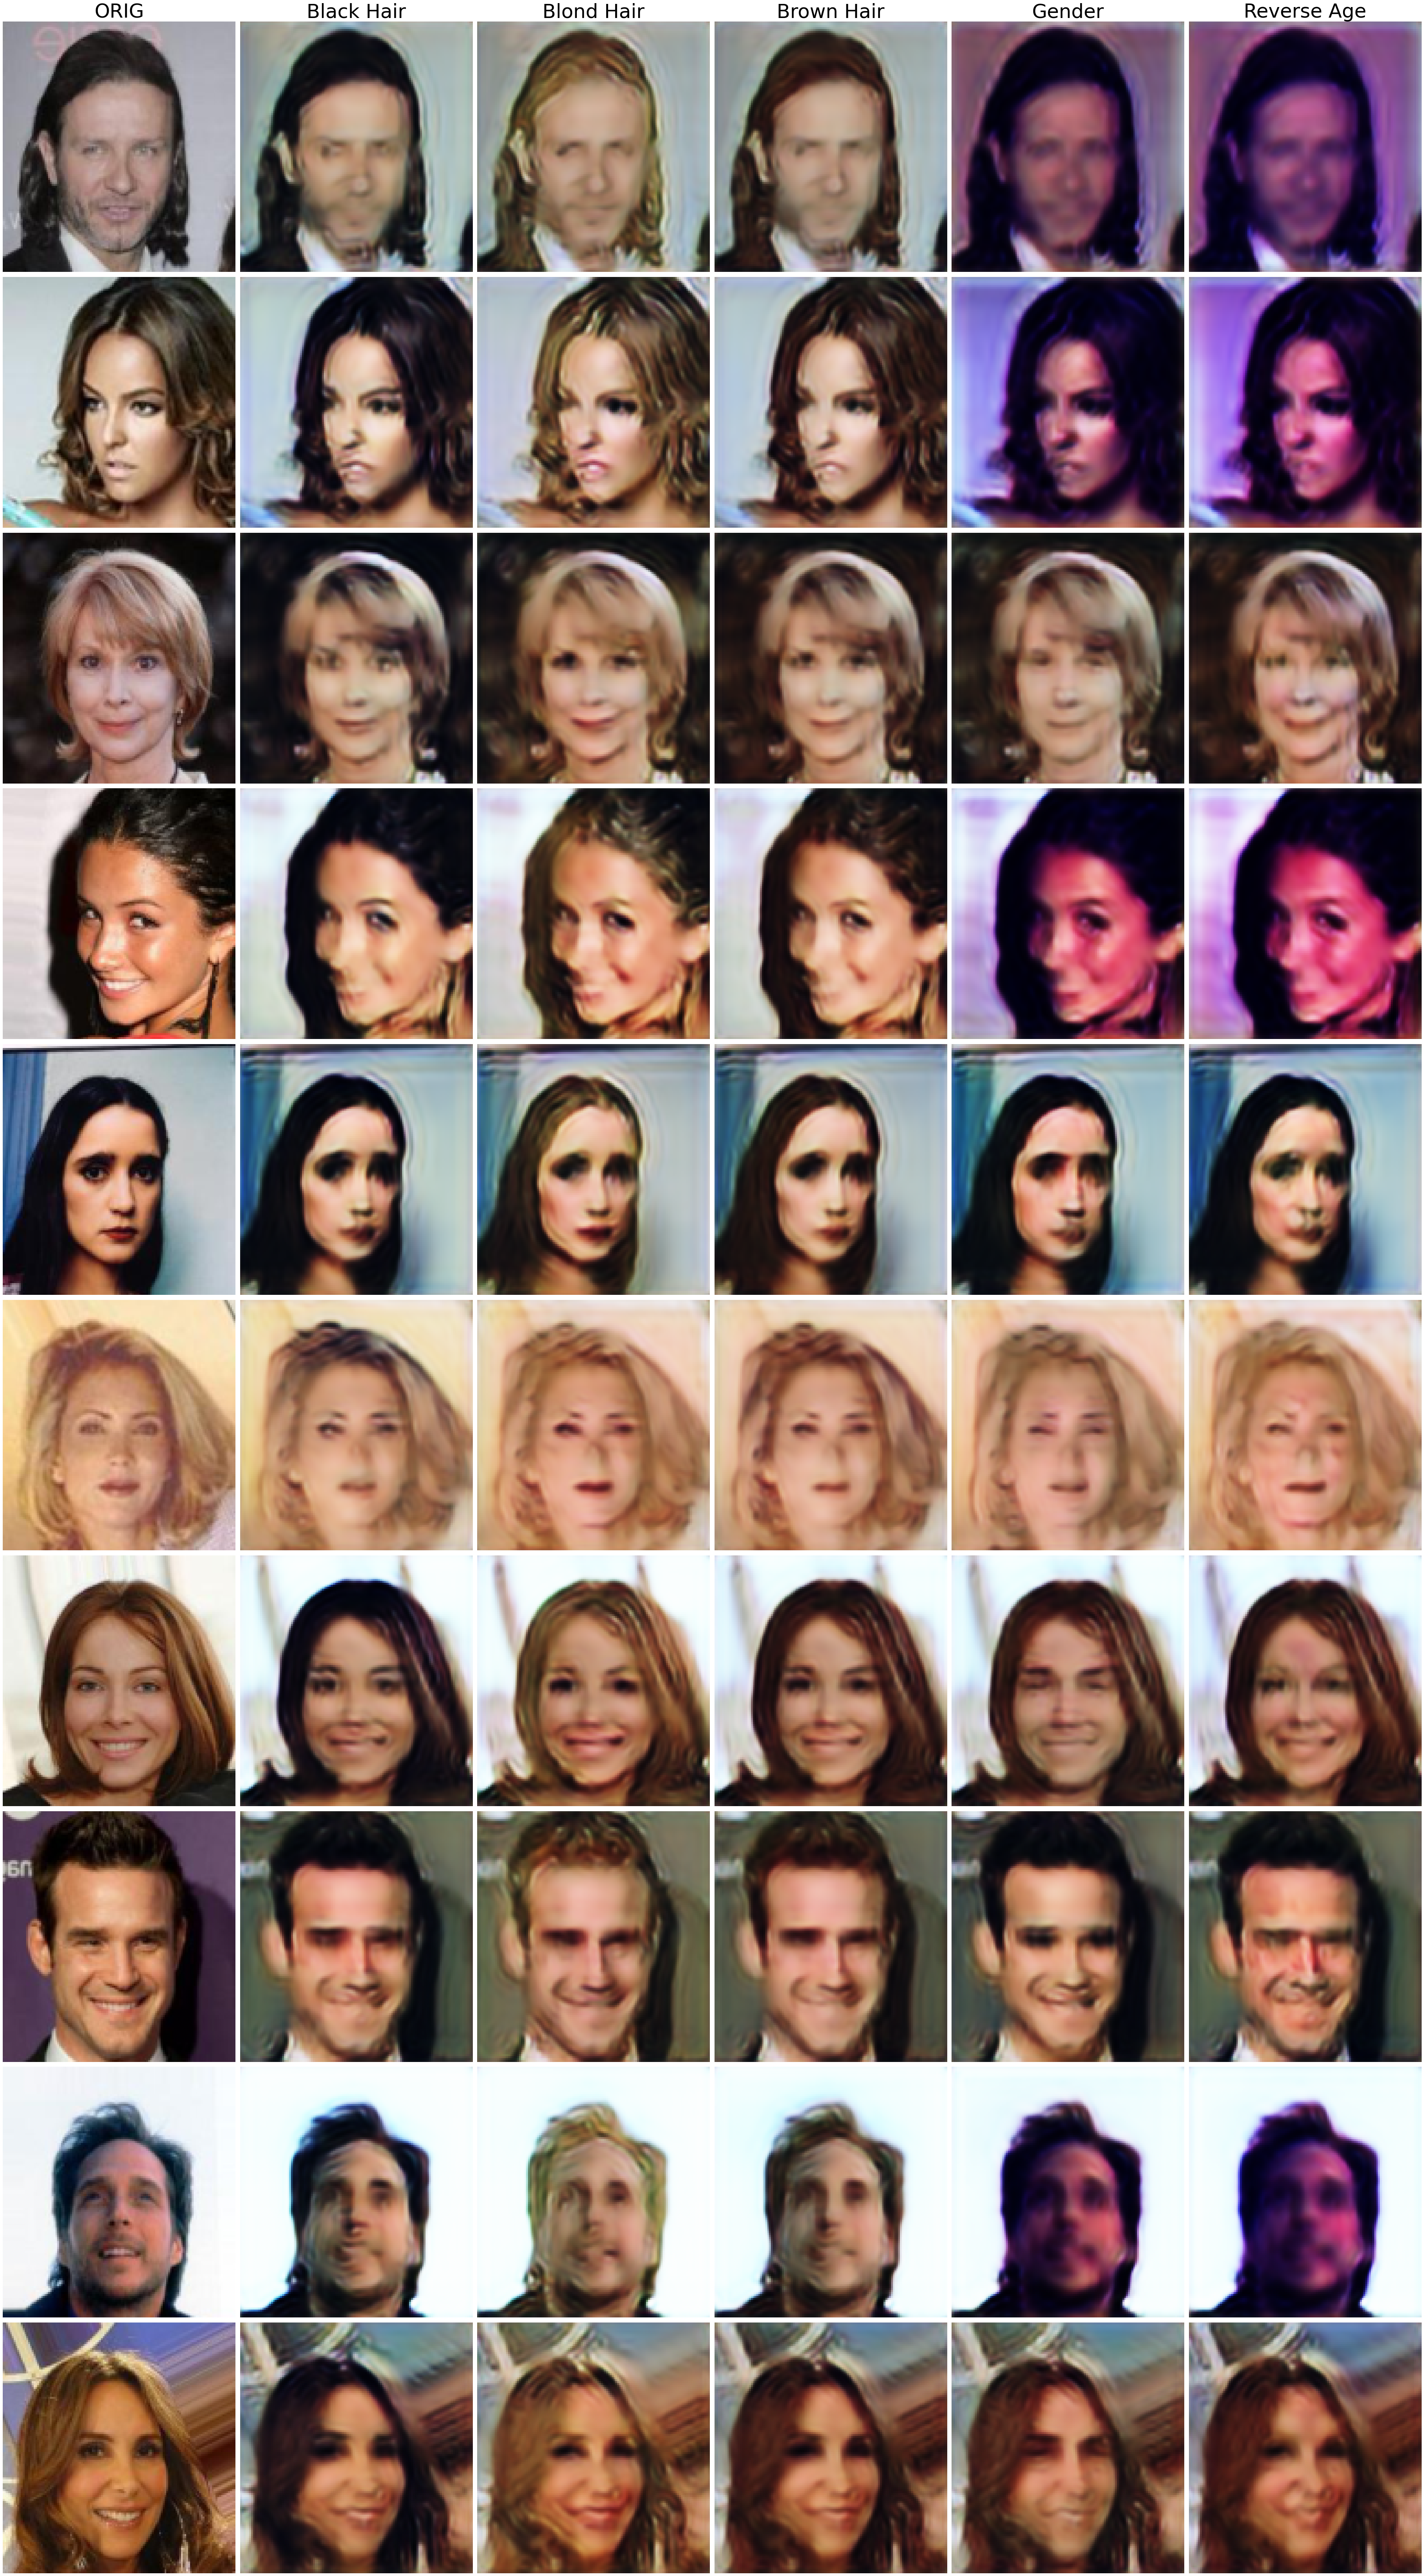

In [115]:
model.eval()
device = config.device
fig, axs = plt.subplots(10, 6, figsize=(65,120))

for ind, (image, label) in enumerate(val_loader): # batch = 1
    if ind >= 10: break
        
        
    axs[ind, 0].imshow((image[0].permute(1, 2, 0) + 1) / 2, aspect='auto')
    axs[ind, 0].axis("off")
    if ind == 0:
        axs[ind, 0].set_title('ORIG', fontsize=50)
    
    
    # пример сравнения качества на глаз:
    for i in range(5):
        tmp = np.array(label[0], dtype=float)[true_domains_nums]
        
        if i >= 3:
            tmp[i] = abs(label[:, true_domains_nums][:, i].item() - 1)     # invert true label
            title = 'Gender' if i == 3 else 'Reverse Age'
        else:
            tmp[i] = 1
            if i == 0:
                title = 'Black Hair'
                tmp[1] = 0
                tmp[2] = 0
            elif i == 1:
                title = 'Blond Hair'
                tmp[0] = 0
                tmp[2] = 0
            else:
                title = 'Brown Hair'
                tmp[0] = 0
                tmp[1] = 0
        
        new_label = torch.Tensor(tmp)
        fake_image = model.generate(image.to(device), new_label.unsqueeze(0).to(device)).detach().cpu()[0]
        axs[ind, i + 1].imshow((fake_image.permute(1, 2, 0) + 1) / 2, aspect='auto')
        axs[ind, i + 1].axis("off")

        if ind == 0:
            axs[ind, i + 1].set_title(title, fontsize=50)
        
plt.subplots_adjust(hspace=0.02, wspace=0.02)    
plt.show()

In [96]:
!git add hw2-GAN.ipynb 

In [97]:
!git commit -m 'misspelling'

[spring-2021 ca6e8b8] misspelling
 1 file changed, 1049 insertions(+), 1037 deletions(-)
 rewrite homework/2-GAN/hw2-GAN.ipynb (86%)


In [99]:
!git push

Counting objects: 5, done.
Delta compression using up to 24 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 981 bytes | 981.00 KiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
remote: This repository moved. Please use the new location:
remote:   https://github.com/Kirili4ik/Deep-Generative-Models.git
To https://github.com/kirili4ik/Deep-Generative-Models
   eabd8df..ca6e8b8  spring-2021 -> spring-2021


## Задача 3 (0.4 балла):

Если вы будете дословно повторять архитектуру авторов статьи, вы сразу же увидите что обучение станет дико долгим и не очень стабильным. Возможно у вас получится предложить несколько улучшений, которые приведут к хорошему FID, к визуально лучшим результатам или к более стабильному обучению.

В этой задаче хочется чтобы вы попробовали улучшить результаты статьи используя либо то что уже знаете, либо что-то из релевантных статей по Im2Im современности

## Важно 6: 

Когда вы будете показывать визуальные трансформации которые делает ваш StarGAN, хорошей идеей будет сразу же зафиксировать набор картинок (очевидно из валидации) и набор трансформаций на которых вы будете показывать результаты. Например: 10 картинок разных людей на которых вы покажете Male-Female, Beard-noBeard, Old-Young трансформации

## Важно 7 (0.15 балла): 

Выдам дополнительные баллы если у вас получится визуально красивая перекраска волос в разные цвета